<a href="https://colab.research.google.com/github/Hyorim-Kim/numpi/blob/main/tfc19transfer_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 이미지 분류기를 직접 작성할 수도 있으나 이미 전문적으로 작성된 모델을 불러, 일부 영역의 학습을 통해
# 작성자가 원하는 모델을 만들 수 있다.
# 전이학습을 하면 방대한 데이터, 우수한 성능의 시스템이 없어도 우수 모델 사용이 가능
# 방법 1 - 특성 추출 기법 : 사전 훈련된 모델의 마지막 완전 연결층 부분만 새로 학습
# 방법 2 - 미세 조정 기법
# 베이스 모델은 MobileNet v2

# %pip install tensorflow-datasets

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 M

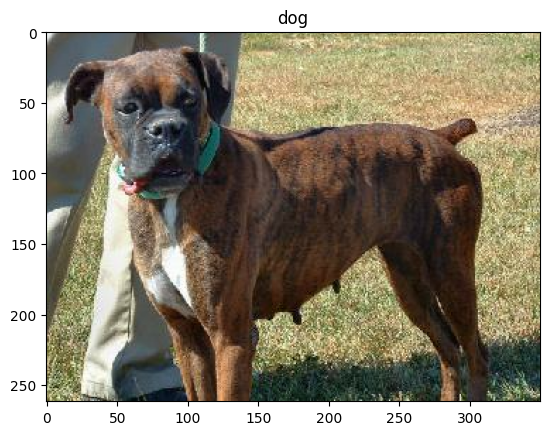

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
          split=['train[:80]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)  # 8:1:1
print(raw_train)
print(raw_train.take(1))
print(raw_validation)
print(raw_test)
print(metadata)

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(1):
  plt.figure()
  plt.imshow(image)
  print(label.numpy())  # 1   tf.Tensor(1, shape=(), dtype=int64)
  plt.title(get_label_name(label))  # dog    cat:0
  plt.show()

# 현재 데이터는 용량이 매우 크기 때문에 ram에 모두 로딩이 불가. 데이터 파이프라인을 이용하면 이미지를 일부만 적당히 연속해서 읽어 처리


In [3]:
# 이미지 포맷팅, 셔플링 처리 : MobileNet v2가 원하기 때문
import tensorflow as tf

IMG_SIZE = 160

def format_exam(image, label):
  image = tf.cast(image, tf.float32)  # 실수화
  image = (image / 127.5) - 1  # 이미지 데이터를 실수화 하고 -1 ~ 1 사이로 크기를 맞춤
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train = raw_train.map(format_exam)
validation = raw_validation.map(format_exam)
test = raw_test.map(format_exam)

# 이미지 배치
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
  pass

print(image_batch.shape, ' ', label_batch.shape)  # (32, 160, 160, 3)   (32,)


(32, 160, 160, 3)   (32,)


In [4]:
# base model 작성 : MobileNet v2 - 대량의 자료로 충분히 학습된 분류 모델
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#  1
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# 입력층 => CNN층(특징 추출) => 완전연결층
# include_top=False를 하면   입력층 => CNN층(특징 추출)

feature_batch = base_model(image_batch)  # (32, 160, 160, 3) 형태의 이미지 특징 반환
# print(feature_batch)  # shape=(32, 5, 5, 1280)

# 계층 동결
base_model.trainable = False  # MobileNet v2는 학습이 끝났으므로 우리가 만들 모델에서는 학습 안함
# print(base_model.summary())

# 모델링
# 2
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()  # AveragePooling2D 보다 급격하게 feature의 수를 줄임
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)  # (32, 5, 5, 1280) => 평균을 사용하므로 5, 5가 축소되어 (32, 1280)

# 3
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)  # (32, 1)

model = tf.keras.Sequential([
    base_model,  # 특징 추출 베이스 모델
    global_average_layer,  # 풀링 레이어
    prediction_layer  # 완전연결층
])


(32, 1280)
(32, 1)


In [5]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
                          loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
print(model.summary())

# 현재 모델 성능 : fit() 전
validation_step = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_step)
print('loss0 : ', loss0)  # 0.7213
print('accuracy0 : ', accuracy0)  # 0.5219

initial_epochs = 10
history = model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None
20/20 [==============================] - 7s 95ms/step - loss: 0.6512 - accuracy: 0.6516
loss0 :  0.6512032747268677
accuracy0 :  0.6515625119209

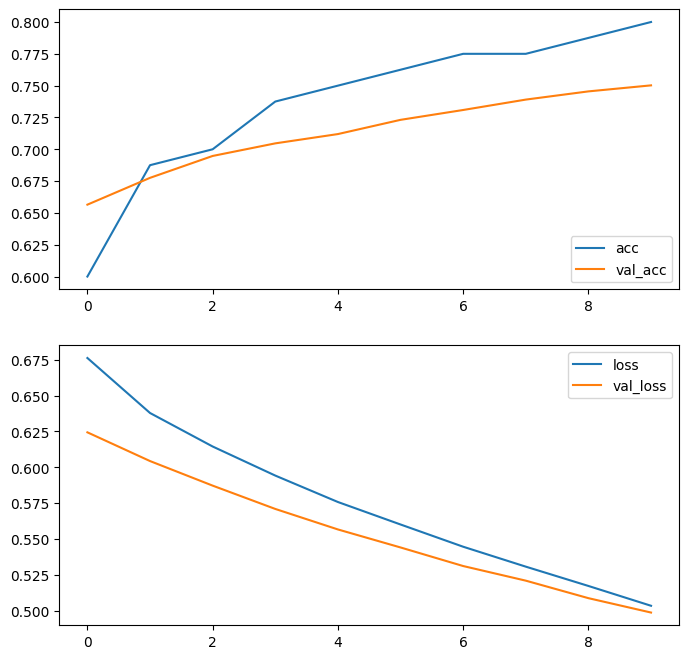

In [7]:
# 학습시 제공된 정보로 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 5))
plt.subplot(2,1,1)
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [10]:
# 파인튜닝(fine-tuning)이란?
# 사전 학습된 인공지능 모델의 가중치를 새로운 데이터에 맞게 세밀하게 조정하여 성능을 향상시키고 학습 시간을 줄이는 과정이다.
# 전이학습이 끝난 모델에 대해 레이어 일부를 재조정하여 더 안정된 모델을 생산
# 베이스 모델의 끝단 레이어 일부도 학습에 참여
base_model.trainable = True  # 베이스 모델의 학습 동결을 해제
print('베이스 모델 레이어 수 : ', len(base_model.layers))  # 154
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False  # 베이스 모델의 앞단 100개는 학습 동결

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10), metrics=['accuracy'])  # 0.00001
print(model.summary())


베이스 모델 레이어 수 :  154
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________
None


Epoch 15/15
3/3 [==============================] - 5s 2s/step - loss: 0.2397 - accuracy: 1.0000 - val_loss: 0.3218 - val_accuracy: 0.8921


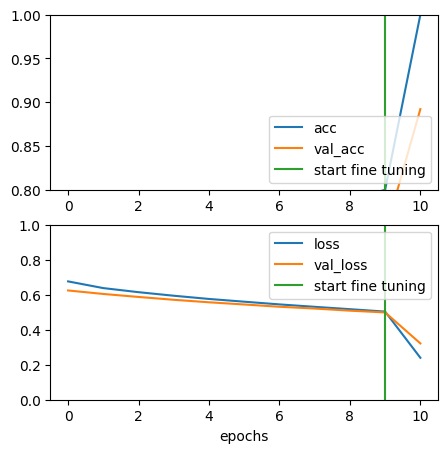

In [12]:
# 파인튜닝 학습
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches, epochs=total_epochs,
                                initial_epoch = history.epoch[-1],
                                validation_data=validation_batches)

# 시각화
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(5, 5))
plt.subplot(2,1,1)
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.ylim([0.8, 1])
plt.plot([initial_epochs -1, initial_epochs -1], plt.ylim(), label='start fine tuning')
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs -1, initial_epochs -1], plt.ylim(), label='start fine tuning')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.show()
